In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ekm(arr,n_clusters,max_iter=10000):
    '''bare-bones implementation of same-sized k-means
    based on https://elki-project.github.io/tutorial/same-size_k_means
    with the following differences:
    1) assumes all clusters are exactly equal in size (otherwise assertion fails)
    2) searches for best improvement across cluster (rather than just top element)
    3) re-sorts by gain (i.e. priority) after each swap'''

    assert len(arr)%n_clusters == 0
    
    # initialize clusters
    iarr, ilabels = ekm_initialize(arr,n_clusters) # keep initial clusters for demo
    
    # first iteration
    arr,labels,alldists,dists,gains = ekm_update(iarr,ilabels,n_clusters)
    
    # continue until there are no more swaps
    flag = True
    i=0
    while gains[0]<0 and flag and i<max_iter:
        i+=1
        flag = False
        outgoing_lbl = labels[0]
        for j in np.argsort(alldists[0]): # search by element gain
            outgoing_gain = alldists[0,j]-dists[0]
            incoming_gain = (alldists[:,outgoing_lbl]-dists)*(labels==j) # ignore other clusters
            mig = np.amin(incoming_gain)
            if mig<0:
                k = np.argmin(incoming_gain)
                labels[0], labels[k] = j, outgoing_lbl
                dists[0], dists[k] = alldists[0,j], alldists[k,outgoing_lbl]
                gains[0], gains[k] = gains[0]-outgoing_gain, gains[k]-mig
                flag=True
                break
        
        arr,labels,alldists,dists,gains = ekm_update(arr,labels,n_clusters)
    
    return arr, labels, iarr, ilabels, i

def ekm_update(arr,labels,n_clusters):
    centers = np.array([np.mean(arr[labels==i],axis=0) for i in range(n_clusters)])
    dists = np.sqrt([np.sum((x-centers[l])**2) for x,l in zip(arr,labels)])
    alldists = np.sqrt(pw_sqdist(arr,centers))
    gains = np.amin(alldists,axis=1)-dists
    return sortby([arr,labels,alldists,dists,gains],gains)
    
def ekm_initialize(arr,n_clusters):
    
    c_size = len(arr)//n_clusters
    
    centers, labels = kmpp(arr,n_clusters)
    alldists = np.sqrt(pw_sqdist(arr,centers))
    arr, labels, alldists = sortby([arr,labels,alldists],np.amin(alldists,axis=1)-np.amax(alldists,axis=1))
    newarr, newlabels, c_totals = [], [], [0]*n_clusters
    while len(arr)>0:
        newarr.append(arr[0,:])
        lbl = labels[0]
        newlabels.append(lbl)
        c_totals[lbl] += 1
        arr, labels, alldists = arr[1:], labels[1:], alldists[1:]
        if (c_totals[lbl] == c_size) and (len(arr)>0):
            alldists[:,lbl] = np.nan
            arr, alldists = sortby([arr,alldists],np.nanmin(alldists,axis=1)-np.nanmax(alldists,axis=1))
            labels = np.nanargmin(alldists,axis=1)
    
    return np.array(newarr), np.array(newlabels)

def pw_sqdist(arr1,arr2):
    '''squared distance between each pair of points in arr1 and arr2
    output[i,j] is the distance between arr1[i,:] and arr2[j,:]'''
    return np.sum((arr1[:,np.newaxis,:]-arr2[np.newaxis,:,:])**2,axis=2)

def proportional_draw(arr,p):
    '''select elements from arr according with probability p (normalized)'''
    c = np.cumsum(p)
    return arr[np.argmax(c > np.random.rand()*c[-1])]

def kmpp(arr,n_clusters):
    '''kmeans++ algorithm'''
    i=0
    centers = []
    mindists = np.ones(len(arr))
    while(i<n_clusters):
        centers.append(proportional_draw(arr,mindists))
        sqdists = pw_sqdist(arr,np.array(centers))
        mindists = np.amin(sqdists,axis=1)
        i=i+1
    return np.array(centers),np.argmin(sqdists,axis=1)

def sortby(arrs,sortarr):
    '''sort arrs by sortarr (in ascending order)'''
    indices = np.argsort(sortarr)
    return [arr[indices] for arr in arrs]

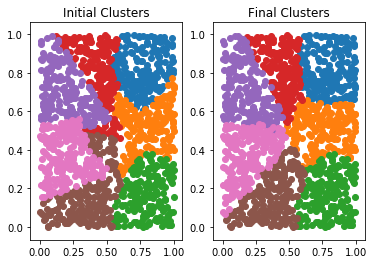

Label Counts: [200 200 200 200 200 200 200]
Total iterations: 129


In [16]:
arr = np.random.rand(1400,2)
arr, labels, iarr, ilabels, n_iter = ekm(arr,7)
fig,ax = plt.subplots(ncols=2)
for i in range(10):
    ax[0].scatter(iarr[ilabels==i,0],iarr[ilabels==i,1])
    ax[1].scatter(arr[labels==i,0],arr[labels==i,1])
ax[0].set_title('Initial Clusters')
ax[1].set_title('Final Clusters')
plt.show()
print('Label Counts:',np.unique(labels,return_counts=True)[1])
print('Total iterations: %i' % n_iter)